In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disease-symptom-description-dataset/symptom_Description.csv
/kaggle/input/disease-symptom-description-dataset/Symptom-severity.csv
/kaggle/input/disease-symptom-description-dataset/symptom_precaution.csv
/kaggle/input/disease-symptom-description-dataset/dataset.csv


In [2]:
pip install transformers datasets torch scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Load and preprocess the dataset
df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')

# Combine symptoms into one column
symptom_cols = [col for col in df.columns if 'Symptom' in col]
df[symptom_cols] = df[symptom_cols].fillna('')
df['symptoms_text'] = df[symptom_cols].agg(' '.join, axis=1).str.lower()

# Encode the target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Disease'])

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['symptoms_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# 2. Tokenization with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# 3. Custom Dataset Class
class SymptomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = SymptomDataset(train_encodings, train_labels)
test_dataset = SymptomDataset(test_encodings, test_labels)

# 4. Model Setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

# 5. Training Setup
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(3):  # 3 epochs
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} complete. Loss: {total_loss / len(train_loader):.4f}")

# 6. Evaluation
test_loader = DataLoader(test_dataset, batch_size=16)
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, preds, target_names=label_encoder.classes_))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 complete. Loss: 1.3174
Epoch 2 complete. Loss: 0.0936
Epoch 3 complete. Loss: 0.0344
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
               

In [ ]:
import pandas as pd 
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

# 1. Load and preprocess the dataset
df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')

# Remove rows with empty Disease or all Symptoms columns empty
df.dropna(subset=['Disease'], inplace=True)
symptom_cols = [col for col in df.columns if 'Symptom' in col]
df.dropna(how='all', subset=symptom_cols, inplace=True)

# Fill remaining symptom NaNs with empty strings and combine symptoms into one column
df[symptom_cols] = df[symptom_cols].fillna('')
df['symptoms_text'] = df[symptom_cols].agg(' '.join, axis=1).str.lower()

# Encode the target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Disease'])

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['symptoms_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# 2. Tokenization with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# 3. Custom Dataset Class
class SymptomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = SymptomDataset(train_encodings, train_labels)
test_dataset = SymptomDataset(test_encodings, test_labels)

# 4. Model Setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

# 5. Training Setup
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
model.train()
for epoch in range(3):  # 3 epochs
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation after each epoch
    model.eval()
    epoch_preds = []
    epoch_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            epoch_preds.extend(predictions.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

    precision = precision_score(epoch_labels, epoch_preds, average='weighted')
    recall = recall_score(epoch_labels, epoch_preds, average='weighted')
    f1 = f1_score(epoch_labels, epoch_preds, average='weighted')
    accuracy = accuracy_score(epoch_labels, epoch_preds)

    print(f"Epoch {epoch+1} complete. Loss: {total_loss / len(train_loader):.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    model.train()

# 6. Final Evaluation
print(classification_report(epoch_labels, epoch_preds, target_names=label_encoder.classes_))

# 7. Prediction input
model.eval()
def predict_disease(symptoms):
    inputs = tokenizer(symptoms.lower(), return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return label_encoder.inverse_transform([prediction])[0]

symptom_input = input("Enter your symptoms separated by spaces: ")
predicted_disease = predict_disease(symptom_input)
print(f"Predicted Disease: {predicted_disease}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 complete. Loss: 1.4576
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000
Epoch 2 complete. Loss: 0.1006
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000
Epoch 3 complete. Loss: 0.0357
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.

Enter your symptoms separated by spaces:  vomiting  headache altered_sensorium


Predicted Disease: Paralysis (brain hemorrhage)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.3175
Epoch 2 - Loss: 0.0881
Epoch 3 - Loss: 0.0329

Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
              

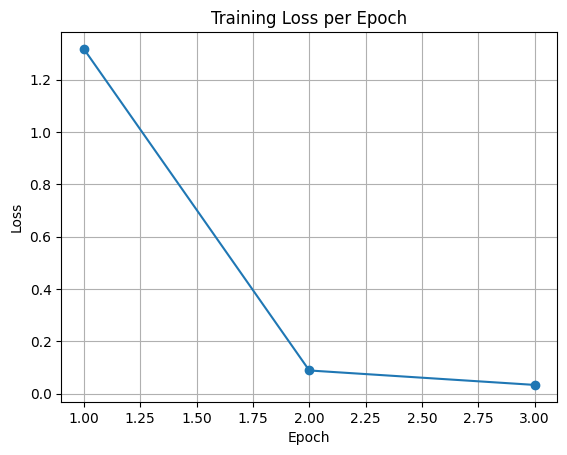

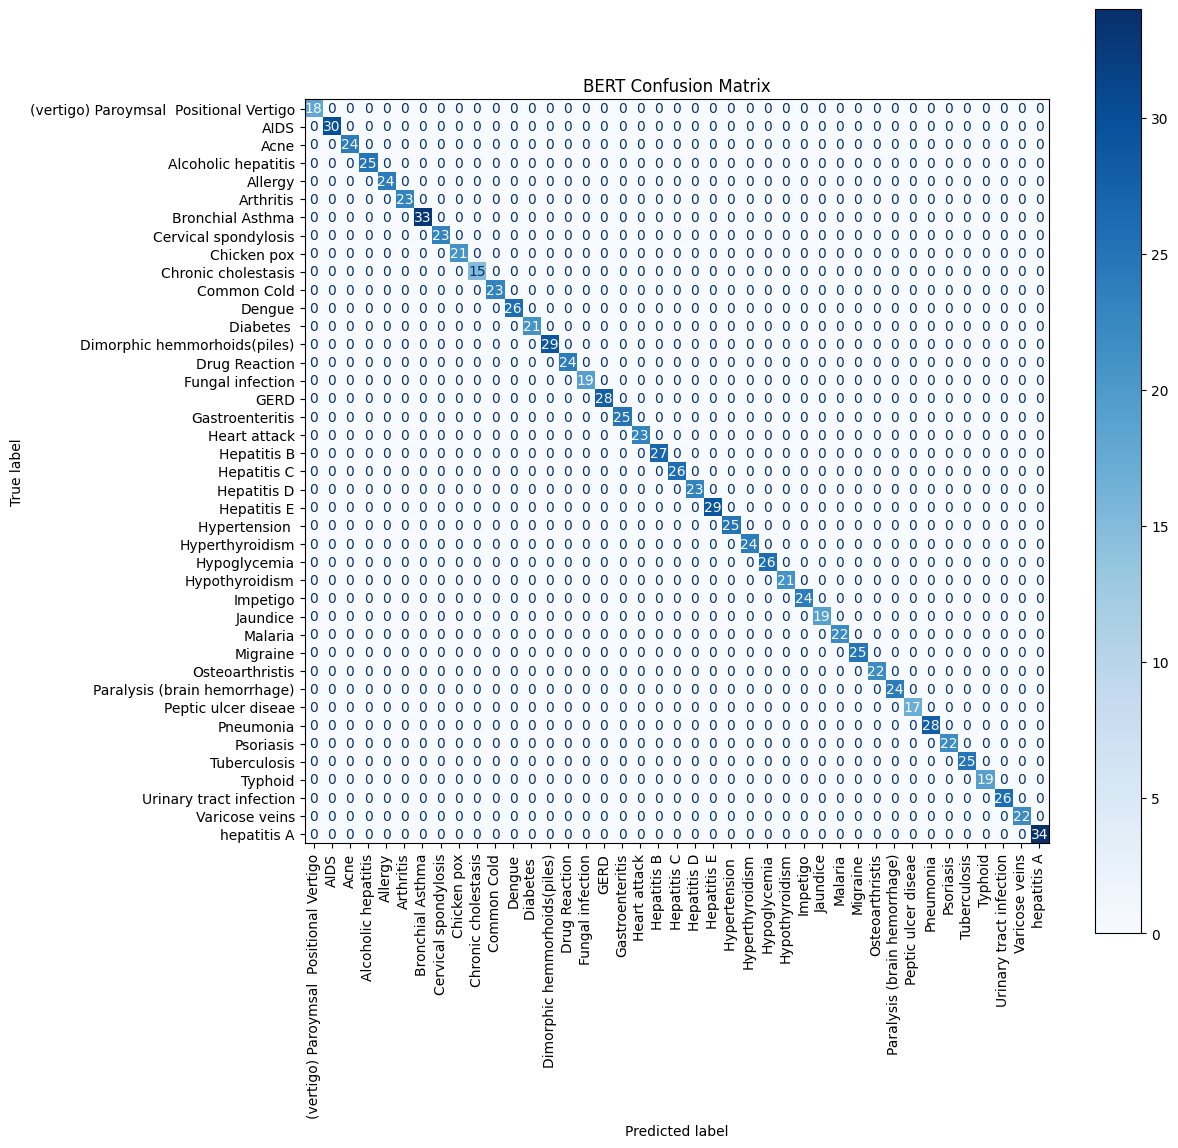

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


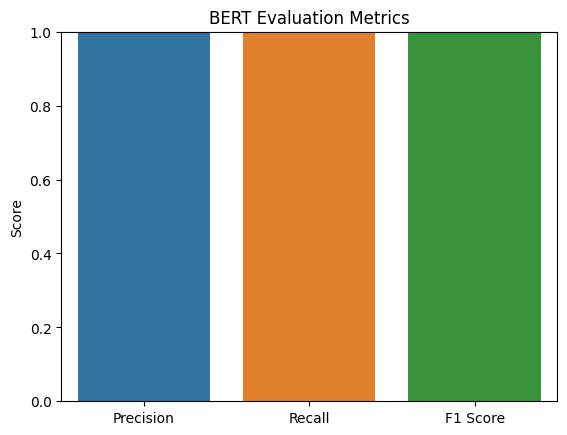

In [6]:
!pip install transformers -q

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess dataset
df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')  # Or your own path
df.dropna(subset=['Disease'], inplace=True)
symptom_cols = [col for col in df.columns if 'Symptom' in col]
df.dropna(how='all', subset=symptom_cols, inplace=True)
df[symptom_cols] = df[symptom_cols].fillna('')
df['symptoms_text'] = df[symptom_cols].agg(' '.join, axis=1).str.lower()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Disease'])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['symptoms_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# 2. Tokenize using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# 3. Custom Dataset Class
class SymptomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = SymptomDataset(train_encodings, train_labels)
test_dataset = SymptomDataset(test_encodings, test_labels)

# 4. BERT Model Setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
optimizer = AdamW(model.parameters(), lr=5e-5)

# 5. Training with Loss Tracking
loss_values = []
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

# 6. Evaluation
model.eval()
epoch_preds = []
epoch_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        epoch_preds.extend(predictions.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

precision = precision_score(epoch_labels, epoch_preds, average='weighted')
recall = recall_score(epoch_labels, epoch_preds, average='weighted')
f1 = f1_score(epoch_labels, epoch_preds, average='weighted')
accuracy = accuracy_score(epoch_labels, epoch_preds)

print("\nClassification Report:\n")
print(classification_report(epoch_labels, epoch_preds, target_names=label_encoder.classes_))

# 7. Visualization

# Training Loss Curve
plt.plot(range(1, len(loss_values)+1), loss_values, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(epoch_labels, epoch_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("BERT Confusion Matrix")
plt.show()

# Bar Plot for Evaluation Metrics
sns.barplot(x=['Precision', 'Recall', 'F1 Score'], y=[precision, recall, f1])
plt.title("BERT Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()
